In [37]:
import numpy as np
import math
import colour
import scipy.constants as const
import scipy
from matplotlib import pyplot as plt
%matplotlib inline

# Optical data link transimpedance amplifier calculations

This notebook calculates the parameters of the TIA we use in the optical data link receivers. Note that we use two sets of parameters because the uplink and downlink parts of the link are asymmetrical. The uplink (stator to rotor) uses a yellow LED and a phototransistor intended for use as an ambient light sensor. The downlink (rotor to stator) uses a standard IR LED and IR photodiode.

The optical calculations here are worst-case calculations, and the real values are likely to be much better. Here, we use a simple model where LED and photodiode are in an infinite vacuum. In the real thing, the two are going to be inside of a small chamber that has high-albedo walls, so a lot of the light that would miss the photodiode in our model here is going to hit it in practice.

## Common parameters

## Uplink (stator to rotor) parameter set

* LED: Osram LY Q396 0603 yellow LED [Datasheet](https://look.ams-osram.com/m/7f3b49fc98442cfa/original/LY-Q396.pdf)
* Receiver: Everlight ALS-PT19-315C/L177 Ambient Light Sensor (phototransistor output) [Datasheet](https://en.everlight.com/wp-content/plugins/ItemRelationship/product_files/pdf/ALS-PT19-315C-L177-TR8_V8.pdf)

## Downlink (rotor to stator) parameter set

* LED: ~~Everlight IR26-21C/L110 1206 package 20° IR LED
[Datasheet](https://www.tme.eu/Document/b8c892bb4ce9fb47542a9a75d00e22cf/IR26-21C-L110-TR8.PDF)~~
    Vishay VSMY2940GX01 2.3x2.3mm lensed IR LED [Datasheet](https://www.vishay.com/docs/84583/vsmy2940rgx01.pdf)
* Receiver: ~~Everlight PD15-21B 1206 package IR **Photodiode**
[Datasheet](https://datasheet.octopart.com/PD15-21B-TR8-Everlight-datasheet-157602352.pdf)~~
    Vishay VBP104FAS 6.4x3.9mm IR photodiode with bandpass, [Datasheet](https://www.vishay.com/docs/81169/vbp104fa.pdf)
* This datasheet is rather poor, so here's a better one for a comparable part: [Vishay VEMD6110X01 Datasheet](https://www.vishay.com/docs/84179/vemd6110x01.pdf)


In [118]:
par = {
    'common': {
        'distance': 10e-3, # Distance from LED to PD/PT in mm
    },
    'uplink': {
        'led_Ie': 145.0e-3/100*20, # Radiant intensity in mW / sr at I_F = 20 mA
        'led_theta': 20, # View angle in degrees
        'led_current': 20e-3, # LED current in mA
        'pd_eff': 32e-6, # Photodiode efficiency ^= short-circuit current at some low reverse voltage at 1 mW/cm^2
        'pd_Ir0': 30e-9, # Photodiode worst-case reverse dark current in A
    },
    'downlink': {
        'als_IPH3': 520e-6, # ALS Photocurrent at 1000 lux from CIE standard illuminant-A
        'led_IV_typ': 60e-3, # typical luminous intensity in Cd
        'als_spectral_response':
        {"x":[299.372,340.167,377.824,426.778,470.711,528.452,569.874,607.531,618.828,627.615,635.146,638.912,652.72,664.017,667.782,685.356,697.908,726.778,749.372,843.515,894.351],"y":[3.659,5.488,9.451,22.866,40.244,63.11,81.402,94.512,96.646,99.695,96.341,79.878,60.366,40.244,32.317,19.512,12.805,9.756,7.927,8.232,7.317]},
        'led_spectral_response':
        {"x":[373.584,439.648,489.746,537.5,554.199,563.281,569.434,574.414,579.688,588.184,590.82,592.578,595.215,597.559,598.145,601.953,606.934,610.742,618.652,630.078,793.555,796.631],"y":[0.005,0.005,0.004,0.002,0.008,0.031,0.067,0.125,0.274,0.806,0.993,0.994,0.776,0.475,0.318,0.185,0.077,0.034,0.01,0.004,0.001,0.004]},
    },
}

for sk in par:
    if sk != 'common':
        for k in par['common']:
            if k not in par[sk]:
                par[sk][k] = par['common'][k]

In [3]:
def calculate_pd_current():
    p = par['uplink'] # Downlink has a phototransistor, not a photodiode
    # cf. https://en.wikipedia.org/wiki/Solid_angle#Pyramid for solid angle conversion
    a = b = 1e-2 # 1 cm square side lengths in m
    d = p['distance']
    # [sr/cm^2]
    angle_norm = 4*math.atan(a*b / (2*d*math.sqrt(4*(d**2) + a**2 + b**2))) # Solid angle of a 1cm^2 square at the target distance
    # irradiance in mW / cm^2 units
    # [mw/sr] * [mA/mA = 1] * [sr / cm^2] = [mw/cm^2]
    irradiance_pd = p['led_Ie'] * p['led_current']/20e-3 * angle_norm
    # [A/(mW/cm^2)] * [mw/cm^2] = [A]
    current_pd = p['pd_eff'] * irradiance_pd # current in A
    print(f'Photodiode irradiance: {irradiance_pd:.3f} mW/cm^2')
    print(f'Photodiode current: {current_pd*1e6:.3f} µA')
    print(f'Photodiode SNR: {20*math.log10(current_pd/p['pd_Ir0'])} dB')
calculate_pd_current()

Photodiode irradiance: 0.023 mW/cm^2
Photodiode current: 0.747 µA
Photodiode SNR: 27.92910861784319 dB


In [125]:
def calculate_pt_current():
    obs = colour.colorimetry.SDS_LEFS_PHOTOPIC['CIE 1924 Photopic Standard Observer']
    spec = par['downlink']['als_spectral_response']
    dis_pt = colour.SpectralDistribution(spec['y'], spec['x']).normalise().interpolate(obs.shape)
    spec = par['downlink']['led_spectral_response']
    dis_led = colour.SpectralDistribution(spec['y'], spec['x']).normalise().interpolate(obs.shape)
    eff = colour.luminous_efficiency(dis_led, dis_pt)
    
    a = b = 1e-2 # [m]
    d = par['downlink']['distance'] # target distance [m]
    # [sr/cm^2]
    angle_norm = 4*math.atan(a*b / (2*d*math.sqrt(4*(d**2) + a**2 + b**2))) # Solid angle of a 1cm^2 square at the target distance
    
    # [lm/m^2] = [Cd = lm/sr] * [sr/cm^2] * 100 * 100
    irr_act = par['downlink']['led_IV_typ'] * angle_norm * 100 * 100
    
    # Reference irradiance = 1000 [lx = lm/m^2]
    irr_ref = 1000
    
    I = par['downlink']['als_IPH3'] * eff * irr_act/irr_ref
    print(f'Phototransistor current I = {I*1e3:.3f} mA')
calculate_pt_current()

Phototransistor current I = 0.231 mA


In [105]:
spec = par['downlink']['als_spectral_response']
x = np.linspace(350, 850, 1000)
y = scipy.interpolate.interp1d(spec['x'], spec['y'])(x) / 100
#plt.plot(x, y)

#area_under_curve = scipy.integrate.cumulative_trapezoid(y, x)[-1]
#normalized_density_per_nm = y / area_under_curve
#plt.twinx().plot(x, normalized_density_per_nm)
#dx = (850 - 350) / 1000
#sum(normalized_density_per_nm * normalized_density_per_nm / dx)
# lx = lm/m^2
# 1000 lm / m^2


0.44303728982398322

0.0016979522350344949

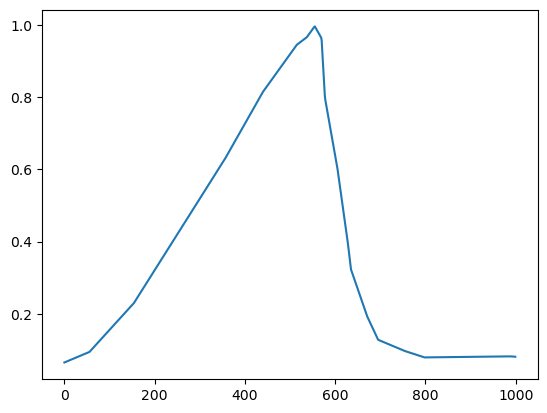

In [85]:
ill = colour.sd_CIE_standard_illuminant_A()
y_ill = scipy.interpolate.interp1d(ill.wavelengths, ill.values, bounds_error=False, fill_value=0.0)(x)

plt.plot(y)

sum(y * y) / sum(y) / sum(y)

In [51]:
1000 / 155 / 100 / 100 * 1e3

0.6451612903225806

In [59]:
8 / 100 / 100 * 1e3

0.8

In [123]:
def calculate_pt_current():
    p = par['downlink'] # Downlink has a phototransistor, not a photodiode
    # cf. https://en.wikipedia.org/wiki/Solid_angle#Pyramid for solid angle conversion
    a = b = 1e-2 # 1 cm square side lengths in m
    d = p['distance']
    # [sr/cm^2]
    angle_norm = 4*math.atan(a*b / (2*d*math.sqrt(4*(d**2) + a**2 + b**2))) # Solid angle of a 1cm^2 square at the target distance

    # Black body power per area (Stefan-Boltzmann Law)
    # ================================================
    
    # Black body temperature of CIE standard illuminant A
    T = 2856 # K
    
    # Note: The emissivity of a black body is 1.0
    # [W/m^2] = [1] * [W m^-2 K^-4] * [K^4]
    power_per_area = 1.0 * const.sigma * T**4

    # [lm/w]
    eff_lm_per_watt = colour.luminous_efficacy(colour.sd_CIE_standard_illuminant_A())
    # [w/m^2] = [lx = lm/m^2] / [lm/w]
    # intensity at test point = 1000 lx
    irr_watt_per_m2 = 1000 / eff_lm_per_watt
    irr_mw_per_cm2 = irr_watt_per_m2 * 1e3 / 100 / 100
    print(f'Irradiance of CIE standard illuminant at 1000 lx is {irr_mw_per_cm2:.3f} mW/cm^2')
    
    obs = colour.colorimetry.SDS_LEFS_PHOTOPIC['CIE 1924 Photopic Standard Observer']
    dis = colour.SpectralDistribution(spec['y'], spec['x']).normalise().interpolate(obs.shape)
    eff_pt = colour.luminous_efficiency(dis) # phototransistor efficiency w.r.t. standard observer
    
    # response in [A / [mw/cm^2]]
    normalized_response = par['downlink']['als_IPH3'] / (irr_mw_per_cm2 * eff_pt)
    print(f'Normalized phototransistor response is {normalized_response*1e3:.3f} mA @ 1mW/cm^2')

calculate_pt_current()

Irradiance of CIE standard illuminant at 1000 lx is 0.642 mW/cm^2
Normalized phototransistor response is 1.049 mA @ 1mW/cm^2



https://en.wikipedia.org/wiki/Transimpedance_amplifier